# Tutorial BuildME

This tutorial shows the most important functionalities of the BuildME framework using a mix of interactive code cells and text cells. The tutorial walks the user through the most important steps shown also in the `main.py` file of the framework. 

During the tutorial, we: 1) select a building archetype and set up the framework, 2) simulate its energy demand using Energy+, 3) calculate its material demand including surrogate elements, 4) process the results. 

## Setting up the framework

### Initial setup

In order for this tutorial to run properly, some initial setup needs to be performed. First, the user needs to install Energy+ software and chosen Python dependencies (eppy, pandas, openpyxl, numpy, tqdm, matplotlib).

The user might need to update the variables listed in `BuildME/settings.py` and in the spreadsheet `BuildME_config_V1.0.xlsx`, given that some variables are automatically read from the spreadsheet. For example, by writing `settings.debug_combinations`, we can access the information provided in the "debug combinations" sheet of the config file.

These steps and other potential setup issues are described [here](https://github.com/nheeren/BuildME/blob/master/docs/setup.md).

### Imports

In [1]:
from BuildME import batch, simulate, settings

### Selection of archetypes


As the next step, we need to define the type(s) of building we want to simulate. We can do that by creating a variable `debug_combinations`. This variable should contain information such as region, occupation and other aspects. The possible combinations of the different aspects are listed in the `settings.combinations` variable. 

Let's say we want to simulate a single family house (**SFH**) located in the **US**. We assume that the building is built without extra requirements on resource efficiency (**RES0**) and that the cooling demand is fulfilled solely using the **HVAC** system. We choose mixed humid climate such as in Baltimore (climate region **4A**) in the reference year **2015**. We are interested in how the energy standard influences the energy use in the building, so we select four different ones: **standard**, **non-standard** (below standard), **efficient** and **ZEB**.

The keywords marked in bold are the categories we insert to our `debug_combinations` dictionary, as shown below. Using the dictionary, the framework can proceed, assuming that the required archetype file (.idf extension) and weather file (.epw extension) are present. 

The archetype files are provided by the framework and can be found in folder `BuildME\data\archetype\USA\`. The weather files need to be created by the user using dedicated software, e.g. Meteonorm, and can be found in folder `BuildME\data\climate\meteonorm71\**reference year**\`. The names of the weather file for each climate are specified in the `climate_stations` variable in `settings.py`. 

If the specific weather file is not found, BuildME uses a dummy weather file for New York, NY (climate region 4A), [made available by the U.S. Department of Energy](https://www.energycodes.gov/prototype-building-models).

In [2]:
my_combinations = {
    'USA':
        {'occupation': ['SFH'],
         'en-std': ['non-standard', 'standard', 'efficient', 'ZEB'],
         'res': ['RES0'],
         'climate_region': ['4A'],
         'climate_scenario': ['2015'],
         'cooling': ['HVAC']}}

The same combinations can also be defined directly in the config file, and automatically read into BuildME. This can be done through the "debug combinations" sheet of the config file, which gets converted into `settings.debug_combinations`.

In [3]:
settings.debug_combinations

{'USA': {'occupation': ['SFH'],
  'en-std': ['non-standard', 'standard', 'efficient', 'ZEB'],
  'res': ['RES0'],
  'climate_region': ['4A'],
  'climate_scenario': ['2015'],
  'cooling': ['HVAC']}}

### Initiating a batch simulation


Based on the chosen archetype combinations, a batch simulation can be initiated. We can  use the function `create_batch_simulation()` to structure the information about each building instance to be simulated, e.g., the location of the .EPW climate file or the IDF building file. 

As part of the function `create_batch_simulation()`, a folder `./tmp/timestamp/` is created, where the timestamp is a unique identifier of this model run based on the current date and time. Under this folder, subfolders are created, one for each combination from `my_combinations`.

As a result, we obtain the dictionary `batch_simulation` and the string `timestamp`.

In [4]:
batch_simulation, timestamp = batch.create_batch_simulation(my_combinations)

Creating batch simulation


## Simulation

The simulation is initiated through the functions `simulate.calculate_energy()` and `simulate.calculate_material()`. If the variable `batch_simulation` is provided into these functions, no other inputs are needed to correctly proceed with the simulation. However, the inputs can also be provided manually (see "One-off simulation" section at the bottom of this document).

### Automatic initialization

Before the actual calculations can be initiated, some preliminary procedures are executed. These procedures are part of the `simulate.calculate_energy()` and `simulate.calculate_material()` functions and are performed automatically.

First, we need to copy the building files. The building files (.IDF) are necessary for both the material and the energy simulation, and thus need to be copied into the specific subfolders of the `./tmp/timestamp/` folder. This is done in the `copy_idf_file()` that is called for each building item in the batch simulation. 

Second, we might need to modify the building files. Th BuildME combinations can include *replacement aspects*, e.g., energy standard ("en-std") or resource efficiency scenario ("res). If they are present, the building file is modified to reflect, e.g. varying thicknesses of insulation layers or air infiltration rates. This is being done automatically through the functions `apply_obj_name_change()` and `apply_rule_from_excel()`. However, this procedure can only be performed if the underlying building files have been pre-adjusted, e.g., using the IDF Converter tool. 

### Energy demand simulation

The actual energy simulation is initiated through `simulate.calculate_energy()` but performed in `energy.perform_energy_calculation()` or `energy.perform_energy_calculation_mp()`, depending on whether parallel computing is activated or not. The simulation is performed using EnergyPlus. 

Please note that the energy simulation takes some time to execute. Depending on the chosen archetype and cooling strategy, it can take between around 20 seconds (e.g., for SFH archetype with HVAC cooling) and more than 15 minutes (e.g., MFH archetype with MMV cooling). After the simulation is done, a prinout message appears below, indicating the number of seconds it took to simulate one building (= one iteration) e.g., 22.26s/it.

In [5]:
simulate.calculate_energy(batch_simulation, parallel=True)

100%|██████████| 1/1 [00:00<00:00, 338.47it/s]


Perform energy simulation on 7 CPUs...


 75%|███████▌  | 3/4 [02:48<00:56, 56.12s/sim]


After performing the energy simulation, the respective folders are filled with simulation files (typically more than 30). The most important of these are:
- `eplusout.err` which informs us about critical errors (in case the simulation did not succeed) or warnings;
- `eplusout.csv` which includes variable values, as listed in the *Output:Variable* object of the IDF file;
- `eplusmtr.csv` which includes metered values, as listed in the *Output:Meter* object of the IDF file.

### Material demand simulation

The actual material demand simulation is initiated through `simulate.calculate_material()` but performed in `material.perform_materials_calculation()`. The material demand calculation is performed in multiple steps. The most important steps include: 
1) listing the building's constructions and the thicknesses of various material layers in `make_construction_dict()`; 
2) calculating the areas of various building surfaces such as walls, floors, ceilings, roof, doors, window glazing in `get_surfaces()`; 
3) matching the constructions types and the areas from the previous steps to get the material volume in `calc_mat_vol_bdg()`; 
4) calculating the material mass by multiplying the volumes from the previous step by material densities in `calc_mat_vol_bdg()`;
5) (optional) adding surrogate elements to the material mass through functions such as `add_surrogate_basement()`.


In [6]:
simulate.calculate_materials(batch_simulation)

100%|██████████| 1/1 [00:00<00:00, 334.21it/s]


Extracting materials and surfaces...
Adding surrogate elements...
Extracting materials and surfaces...
Adding surrogate elements...
Extracting materials and surfaces...
Adding surrogate elements...
Extracting materials and surfaces...
Adding surrogate elements...


After performing this step, a file `mat_demand.csv` and `geom_stats.csv` is created in each respective subfolder. The file `mat_demand.csv` contains the mass of various material types (kg) contained in the entire building. The file `geom_stats.csv` contains information about the building geometry, such as the floor area of the building, the area of external walls, etc.

## Post-processing and plotting

### Post-processing the results

After all the simulations have been performed, the results can be processed and structured. It is being done in multiple steps, all of which are optional:
- `simulate.aggregate_energy()`: in each subfolder, creates a file *energy_demand.csv* to summarize the chosen variables from *eplusout.csv*. Allows various energy units, such as J, MJ (default), and kWh.
- `simulate.aggregate_materials()`: in each subfolder, creates a file *mat_demand_aggregated.csv* which aggregates material types into categories defined in *settings.material_aggregation*, e.g., 'concrete', 'brick', 'paper and cardboard', etc. The file *mat_demand_categorized.csv* is also created to help with potential debugging, listing material types assigned to categories but not summed up. 
- `simulate.calculate_intensities()`: calculates energy and material demand intensities, i.e., energy and material demand per (m<sup>2</sup>) of the floor area. In each subfolder, creates files *energy_demand_m2.csv*, *mat_demand_m2.csv* and *mat_demand_aggregated_m2.csv*. 
- `simulate.collect_results()`: collects all the previously created *\*.csv* files with results and saves them into *summary_\*.csv* files in the main simulation folder (*.\tmp\timestamp\\*).
- `simulate.weighing_climate_region()`: weighs the results of the energy simulation according to climate regions. Only useful if all climate types of a given region are simulated (e.g., 5 climate regions in China or 16 climate regions in USA).
- `simulate.cleanup()`: allows to clean up the simulation folders by deleting the temporary files (everything in the subfolders), archiving them into a .zip file, or both. 


In [7]:
simulate.aggregate_energy(batch_simulation, unit='kWh')
simulate.aggregate_materials(batch_simulation)
simulate.calculate_intensities(batch_simulation)
simulate.collect_results(batch_simulation)
# simulate.weighing_climate_region(batch_simulation)
# simulate.cleanup(batch_simulation, archive=False, del_temp=True)

### Data visualization - table

At this point, the results for all building combinations can be visualized using a few simple data manipulation steps performed with the use of the `pandas` and `numpy` library. Below, we can see the energy intensity (kWh/m2) and material intensity (kg/m2) of the simulated buildings.

In [8]:
import pandas as pd
import numpy as np
import os
# fnames = batch.find_and_load_last_run()
# run = os.path.basename(os.path.dirname(fnames[list(fnames.keys())[0]]['run_folder']))
df_ene = pd.read_csv('.//tmp//'+timestamp+'//summary_energy_demand_m2.csv')  # , index_col=[0, 1, 2, 3, 4, 5, 6])
df_mat = pd.read_csv('.//tmp//'+timestamp+'//summary_mat_demand_aggregated_m2.csv')  # , index_col=[0, 1, 2, 3, 4, 5, 6])
energy_unit = df_ene['Unit'][0]
material_unit = df_mat['Unit'][0]
df_ene = df_ene.drop(columns=['region', 'occupation', 'res', 'climate_region', 'climate_scenario', 'cooling', 'Building name', 'Unit']) # keep 'en-std'
df_mat = df_mat.drop(columns=['region', 'occupation', 'res', 'climate_region', 'climate_scenario', 'cooling', 'Building name', 'Unit']) # keep 'en-std'
df_ene = df_ene[df_ene['EnergyPlus output variable'] != 'TOTAL']
df_mat = df_mat[df_mat['Material type'] != 'TOTAL']
df_ene = df_ene.set_index(['en-std', 'EnergyPlus output variable'])
df_mat = df_mat.set_index(['en-std', 'Material type'])
df_ene = df_ene.unstack(level=-1)
df_mat = df_mat.unstack(level=-1)

### Data visualization - simple

We can now plot the results using the *matplotlib* library. 

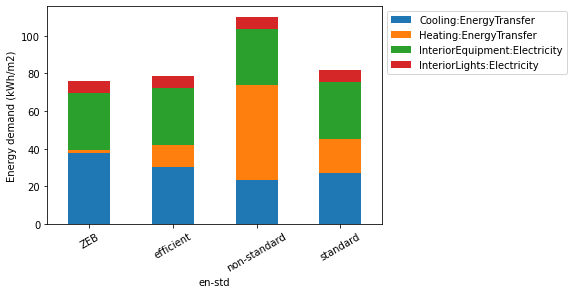

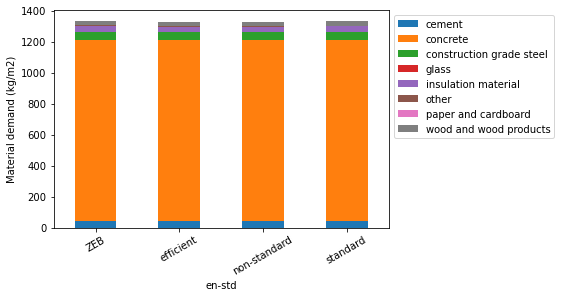

In [9]:
import matplotlib.pyplot as plt
(df_ene['Value']).plot.bar(rot=30, stacked=True, label=df_mat.index)
plt.ylabel(f"Energy demand ({energy_unit})")
plt.legend(bbox_to_anchor=(1,1))  
plt.show()
(df_mat['Value']).plot.bar(rot=30, stacked=True, label=df_mat.index)
plt.ylabel(f"Material demand ({material_unit})")
plt.legend(bbox_to_anchor=(1,1))  
plt.show()

As the material results seem very similar, we plot them again, but now after scaling each material category such that 100% reflects the maximum value in each material category. 

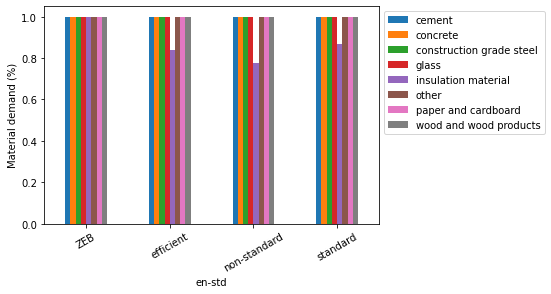

In [10]:
(df_mat['Value']/df_mat['Value'].max()).plot.bar(rot=30, stacked=False, label=df_mat.index)
plt.ylabel(f"Material demand (%)")
plt.legend(bbox_to_anchor=(1,1))  
plt.show()

## One-off simulation

As presented above, BuildME can perform efficient batch simulations of energy and material efficiency in buildings. However, the framework can also perform one-off simulation of a single building. An example is presented below.

Please note that the simulation includes the variable replace_dict, which indicates that *replacement aspects* should be taken into account. However, this procedure can only be performed if the underlying building file has been pre-adjusted, e.g., using the IDF Converter tool. 

In [3]:
import os 
ep_dir = os.path.abspath("./bin/EnergyPlus-9-2-0/")
epw_path = os.path.abspath("./data/climate/USA_NY_New.York-dummy.epw")
csv_dir = os.path.abspath("./data/")
material_csv_path = os.path.abspath("./data/material.csv")
idf_path = os.path.abspath("./data/archetype/USA/SFH.idf")
out_dir = os.path.abspath("./tmp/test/")
archetype = 'SFH'
en_std = 'standard'
simulate.calculate_materials(out_dir=out_dir, idf_path=idf_path, archetype=archetype, replace_csv_dir=csv_dir,
                            material_csv_path=material_csv_path, ep_dir=ep_dir, epw_path=epw_path,
                            replace_dict={'en-std': en_std, 'res': 'RES0'}, clear_folder=False, surrogates=True, 
                            surrogates_dict={'basement':{'height': 0.2, 'materials': 'Concrete_surrogate', 'densities': 2400}})
simulate.calculate_energy(out_dir=out_dir, idf_path=idf_path, archetype=archetype, replace_csv_dir=csv_dir,
                          material_csv_path=material_csv_path, ep_dir=ep_dir, epw_path=epw_path,
                          replace_dict={'en-std': en_std, 'res': 'RES0'}, clear_folder=False)
simulate.aggregate_energy(folders=[out_dir], unit='kWh')
simulate.aggregate_materials(folders=[out_dir], aggreg_dict=settings.material_aggregation)
simulate.calculate_intensities(folders=[out_dir])

100%|██████████| 1/1 [00:00<00:00, 501.17it/s]


Extracting materials and surfaces...
Adding surrogate elements...


100%|██████████| 1/1 [00:00<00:00, 501.41it/s]

Perform energy simulation...


Energy simulation successful in folder 'test'
